In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML

import random
import math
import itertools
import networkx as nx

from scipy.spatial.distance import euclidean

### Mapping The Store

In [2]:
# Store layout
store_layout = {
    # Vertical Aisles - left to right
    "A1":  {"x_start": 3,   "x_end": 5,  "y_start": 3,   "y_end": 11},
    "A2":  {"x_start": 3,   "x_end": 5,  "y_start": 14,   "y_end": 24},
    "A3":  {"x_start": 7,   "x_end": 9,  "y_start": 3,   "y_end": 10},
    "A4":  {"x_start": 7,  "x_end": 9, "y_start": 13,   "y_end": 24},
    "A5":  {"x_start": 11,  "x_end": 13, "y_start": 3,   "y_end": 10},
    "A6":  {"x_start": 11,   "x_end": 13,  "y_start": 13,  "y_end": 24},
    "A7":  {"x_start": 15,  "x_end": 17, "y_start": 3,   "y_end": 10},
    "A8":  {"x_start": 15,   "x_end": 17,  "y_start": 13,  "y_end": 24},
    "A9":  {"x_start": 19,   "x_end": 21,  "y_start": 3,   "y_end": 11},
    "A10": {"x_start": 19,   "x_end": 21,  "y_start": 14,   "y_end": 24},
    "A11": {"x_start": 23,  "x_end": 25, "y_start": 3,   "y_end": 10},
    "A12": {"x_start": 23,   "x_end": 25,  "y_start": 13,  "y_end": 24},

    # Corner Aisles
    "C1":  {"x_start": 0,   "x_end": 1,  "y_start": 3,   "y_end": 15},
    "C2":  {"x_start": 0,   "x_end": 1,  "y_start": 19,  "y_end": 28},
    "C3":  {"x_start": 2,   "x_end": 15,   "y_start": 27,  "y_end": 28},
    "C4":  {"x_start": 17,   "x_end": 27,   "y_start": 27,   "y_end": 28},
    "C5":  {"x_start": 27,  "x_end": 28, "y_start": 3,   "y_end": 24},

    "Gate":  {"x_start": 1,  "x_end": 2, "y_start": 0,   "y_end": 1}
    }

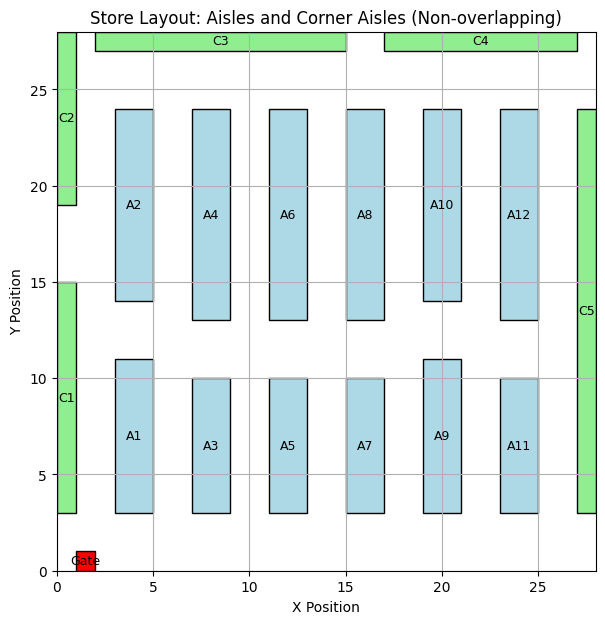

In [3]:
# Plotting
fig, ax = plt.subplots(figsize=(7, 7))

for aisle_id, coords in store_layout.items():
    width = coords["x_end"] - coords["x_start"]
    height = coords["y_end"] - coords["y_start"]

    if aisle_id.startswith("C"):
        color = 'lightgreen'
    elif aisle_id.startswith("Gate"):
        color = 'red'
    else:
        color = 'lightblue'

    rect = plt.Rectangle((coords["x_start"], coords["y_start"]), width, height,
                         edgecolor='black', facecolor=color)
    ax.add_patch(rect)

    # Add label
    ax.text(coords["x_start"] + width/2, coords["y_start"] + height/2,
            aisle_id, ha='center', va='center', fontsize=9, color='black')

# Set bounds and grid
ax.set_xlim(0, 28)
ax.set_ylim(0, 28)
ax.set_title("Store Layout: Aisles and Corner Aisles (Non-overlapping)")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_aspect('equal')
plt.grid(True)
plt.show()

### Building A Navigable Graph/Grid:

##### Adding Grid Bounds & Blocked Paths:

- Define a grid layout.
- Iterate through each aisle in store_layout
- For each aisle, mark the cells it occupies as blocked (i.e., not walkable)

In [4]:
# Compute grid size based on store layout

x_values = [v["x_start"] for v in store_layout.values()] + [v["x_end"] for v in store_layout.values()]
y_values = [v["y_start"] for v in store_layout.values()] + [v["y_end"] for v in store_layout.values()]


x_min, x_max = int(min(x_values)), int(max(x_values))
y_min, y_max = int(min(y_values)), int(max(y_values))


grid_width = x_max + 1
grid_height = y_max + 1

In [5]:
print(f"Grid dimensions: width={grid_width}, height={grid_height}")
print(f"x range: {x_min} to {x_max}, y range: {y_min} to {y_max}")

Grid dimensions: width=29, height=29
x range: 0 to 28, y range: 0 to 28


In [6]:
# Set of blocked cells
blocked_cells = set()

# Mark all aisle cells as blocked
for aisle in store_layout.values():
    for x in range(int(aisle["x_start"]), int(aisle["x_end"])):
        for y in range(int(aisle["y_start"]), int(aisle["y_end"])):
            blocked_cells.add((x, y))

##### Implementing Logic for Walkable Grid & Creating Dict Graph:

- Create a 2D grid based on your store dimensions
- Mark obstacles (aisles, walls) on that grid
- Loop over every walkable cell and connect it to its up/down/left/right neighbors → this creates your adjacency list (dictionary)
- Later (if needed), convert that dictionary into a NetworkX Graph for analysis or visualization

In [7]:
# Initialize grid with all walkable cells (True means walkable)
grid = [[True for _ in range(grid_width)] for _ in range(grid_height)]

In [8]:
# Mark all aisle and corner aisle regions as False (not walkable)
for coords in store_layout.values():
    for x in range(coords["x_start"], coords["x_end"]):
        for y in range(coords["y_start"], coords["y_end"]):
            if 0 <= x < grid_width and 0 <= y < grid_height:
                grid[y][x] = False  # Remember: grid[y][x] because rows are y-axis

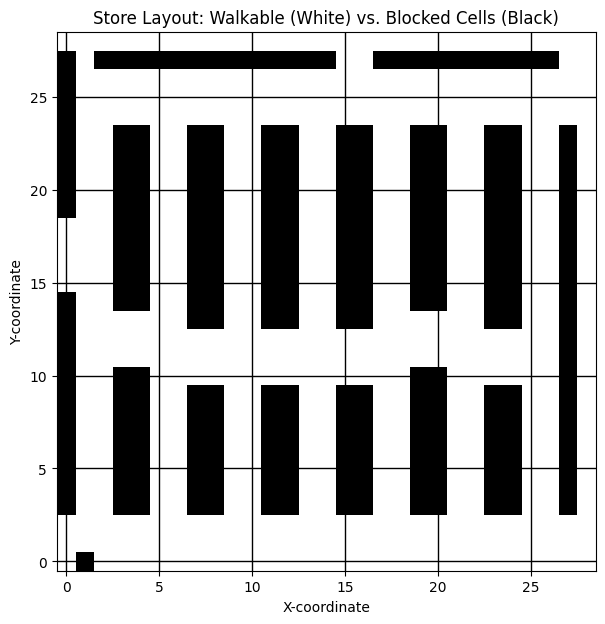

In [9]:
# Convert grid to numpy array for easy visualization
grid_np = np.array(grid)

# Create a plot
plt.figure(figsize=(10, 7))

# Plot the grid
plt.imshow(grid_np, cmap="gray", origin="upper", interpolation="nearest")

# Invert y-axis to match traditional grid system
plt.gca().invert_yaxis()

# Add gridlines for better visibility of cells
plt.grid(True, color='black', linestyle='-', linewidth=1)

# Set title and axis labels
plt.title("Store Layout: Walkable (White) vs. Blocked Cells (Black)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Show the plot
plt.show()

##### Using Network X To Map Store & Logics:

In [10]:
import networkx as nx

# Step 1: Initialize graph
G = nx.Graph()

# Step 2: Identify blocked cells (same as your existing logic)
blocked_cells = set()
for aisle in store_layout.values():
    for x in range(int(aisle["x_start"]), int(aisle["x_end"])):
        for y in range(int(aisle["y_start"]), int(aisle["y_end"])):
            blocked_cells.add((x, y))

# Step 3: Add walkable cells as nodes in the graph
for x in range(grid_width):
    for y in range(grid_height):
        if (x, y) not in blocked_cells:
            G.add_node((x, y))

In [11]:
# Define possible moves: up, down, left, right
moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]

for (x, y) in G.nodes():
    for dx, dy in moves:
        neighbor_x, neighbor_y = x + dx, y + dy
        if (neighbor_x, neighbor_y) in G:
            G.add_edge((x, y), (neighbor_x, neighbor_y))

In [12]:
# Manhattan distance function (you can replace it with Euclidean if needed)
def manhattan_distance(node1, node2):
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])

# Add edges with weights (Manhattan distance between adjacent nodes)
for (x, y) in G.nodes():
    for dx, dy in moves:
        neighbor_x, neighbor_y = x + dx, y + dy
        if (neighbor_x, neighbor_y) in G:
            distance = manhattan_distance((x, y), (neighbor_x, neighbor_y))
            G.add_edge((x, y), (neighbor_x, neighbor_y), weight=distance)

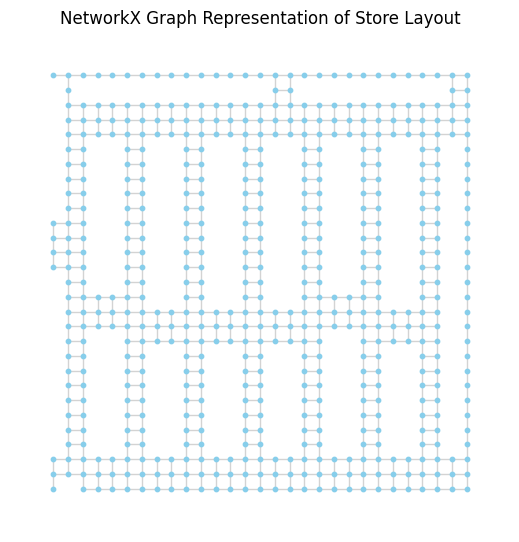

In [13]:
# Use node (x, y) positions directly
pos = {node: node for node in G.nodes()}

plt.figure(figsize=(5, 5))
nx.draw(G, pos=pos,
        node_size=10,
        node_color="skyblue",
        edge_color="lightgray",
        with_labels=False)

plt.title("NetworkX Graph Representation of Store Layout")
plt.grid(True)
plt.show()

1. Identify Adjacent Cells to Aisles:

- For each aisle (blocked cell), we will look at its neighboring cells in all four directions (up, down, left, right) to find the walkable adjacent cells.
- We'll place items in those walkable adjacent cells.
- Pickers can reach them, since those cells are part of the graph.


2. Set Gate as Starting Point:

- Set the start point as any of the walkable coordinates within the gate area.

In [14]:
# Gate already defined in our store_layout
# "Gate": {"x_start": 1, "x_end": 2, "y_start": 0, "y_end": 1}

In [15]:
item_nodes = set()

# Directions: up, down, left, right
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

for x, y in blocked_cells:
    for dx, dy in directions:
        nx_, ny_ = x + dx, y + dy

        # Check if within bounds and in G (i.e., walkable)
        if 0 <= nx_ < grid_width and 0 <= ny_ < grid_height and (nx_, ny_) in G:
            item_nodes.add((nx_, ny_))

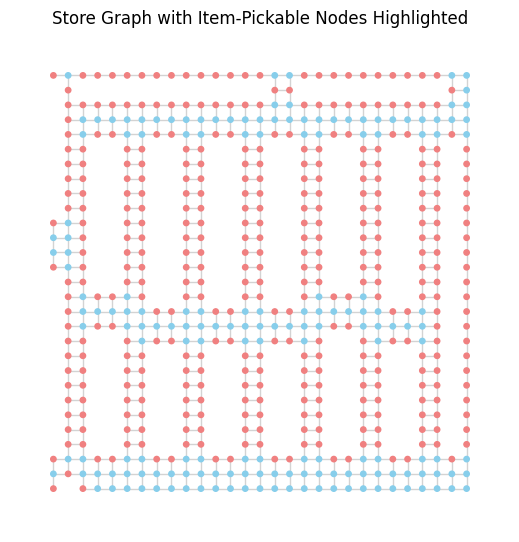

In [16]:
# Create a color map: red for item nodes, blue for others
node_colors = []
for node in G.nodes():
    if node in item_nodes:
        node_colors.append("lightcoral")
    else:
        node_colors.append("skyblue")

# Use node positions (they're already (x, y))
pos = {node: node for node in G.nodes()}

plt.figure(figsize=(5, 5))
nx.draw(G, pos=pos,
        node_size=15,
        node_color=node_colors,
        edge_color="lightgray",
        with_labels=False)

plt.title("Store Graph with Item-Pickable Nodes Highlighted")
plt.grid(True)
plt.show()

### Using Pathfinding Algorithms To Test The Space:

##### Scenario 1: 1 Item

In [17]:
# Starting point (Gate)
start = (1, 1)

In [18]:
# Randomly place 1 item in a walkable cell (not blocked and not the start)
item_location = random.choice(list(item_nodes))

In [19]:
# Dijkstra path
path_dijkstra = nx.shortest_path(G, source=start, target=item_location, weight=None, method='dijkstra')

# A* path
path_astar = nx.astar_path(G, source=start, target=item_location, heuristic=lambda a, b: abs(a[0] - b[0]) + abs(a[1] - b[1]))

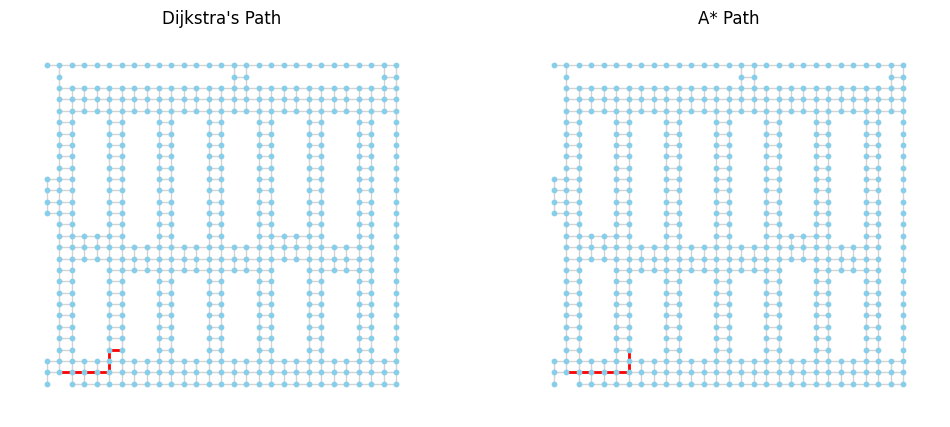

In [20]:
# Create subplots for both graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Dijkstra's Path
pos = {node: node for node in G.nodes()}
nx.draw(G, pos=pos, ax=axes[0], node_size=10, node_color="skyblue", edge_color="lightgray", with_labels=False)
path_edges_dijkstra = list(zip(path_dijkstra[:-1], path_dijkstra[1:]))
nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges_dijkstra, edge_color='red', width=2, ax=axes[0])
axes[0].set_title("Dijkstra's Path")

# Plot A* Path
nx.draw(G, pos=pos, ax=axes[1], node_size=10, node_color="skyblue", edge_color="lightgray", with_labels=False)
path_edges_astar = list(zip(path_astar[:-1], path_astar[1:]))
nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges_astar, edge_color='red', width=2, ax=axes[1])
axes[1].set_title("A* Path")

plt.show()

##### Scenario 2: 5 Items

In [21]:
# Randomly place 5 items in walkable cells (not blocked and not the start)
num_items = 5
item_locations = random.sample(list(item_nodes), num_items)

In [22]:
# Run Dijkstra's Algorithm for each item
dijkstra_paths = []
for item_location in item_locations:
    path_dijkstra = nx.dijkstra_path(G, source=start, target=item_location)
    dijkstra_paths.append(path_dijkstra)

# Run A* Algorithm for each item
astar_paths = []
for item_location in item_locations:
    path_astar = nx.astar_path(G, source=start, target=item_location, heuristic=lambda x, y: abs(x[0] - y[0]) + abs(x[1] - y[1]))
    astar_paths.append(path_astar)

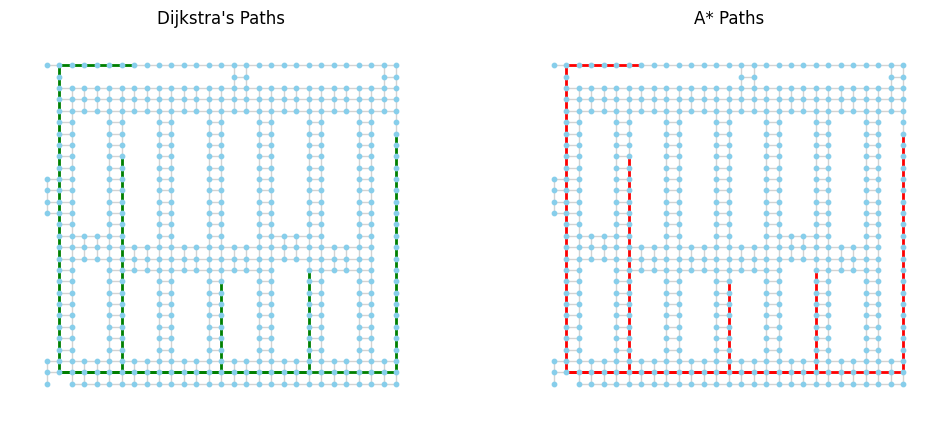

In [23]:
# Create subplots for both graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Dijkstra's Paths
pos = {node: node for node in G.nodes()}
nx.draw(G, pos=pos, ax=axes[0], node_size=10, node_color="skyblue", edge_color="lightgray", with_labels=False)
for path_dijkstra in dijkstra_paths:
    path_edges_dijkstra = list(zip(path_dijkstra[:-1], path_dijkstra[1:]))
    nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges_dijkstra, edge_color='green', width=2, ax=axes[0])
axes[0].set_title("Dijkstra's Paths")

# Plot A* Paths
nx.draw(G, pos=pos, ax=axes[1], node_size=10, node_color="skyblue", edge_color="lightgray", with_labels=False)
for path_astar in astar_paths:
    path_edges_astar = list(zip(path_astar[:-1], path_astar[1:]))
    nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges_astar, edge_color='red', width=2, ax=axes[1])
axes[1].set_title("A* Paths")

plt.show()

### Using TSP To Solve Route Optimization:

#### Scenario 1: 10 Items

##### Picker's Original Path

In [24]:
# Gate position
gate_position = (1,1)

# Randomly place 5 items in walkable cells (not blocked and not the start)
num_items = 10
item_locations = random.sample(list(item_nodes), num_items)

In [25]:
# Creating a random sequence in which to pick the items
random_sequence = random.sample(item_locations, len(item_locations))

# Creating a full path that a picker would take
full_path_nodes = [gate_position] + random_sequence + [gate_position]

In [26]:
# Collecting paths using Dijkstra (Switch to A* if needed)
full_path = []
for i in range(len(full_path_nodes) - 1):
    segment = nx.shortest_path(G, full_path_nodes[i], full_path_nodes[i + 1], weight='weight')
    full_path += segment[:-1]  # omit last to avoid duplication
full_path.append(gate_position)  # add final return to gate

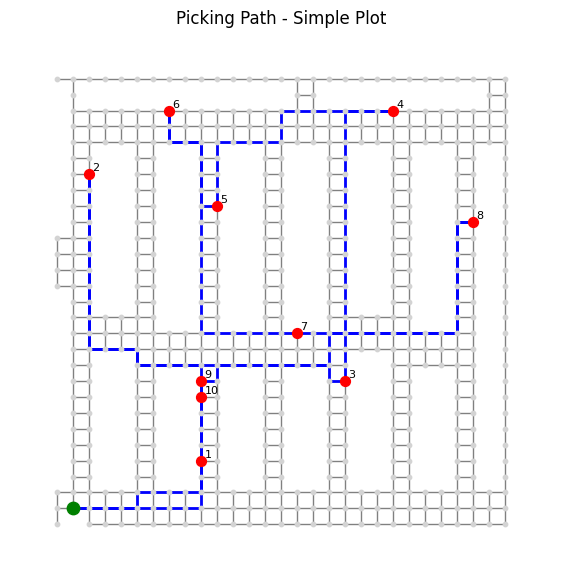

In [27]:
# 4. Visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Picking Path - Simple Plot")

# Draw the static elements: graph and nodes (static)
nx.draw(G, pos=pos, node_size=10, node_color="lightgray", edge_color="gray", with_labels=False, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=item_locations, node_color="red", node_size=50, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=[gate_position], node_color="green", node_size=80, ax=ax)

# Label items with picking order (1-based index)
for idx, node in enumerate(random_sequence, 1):
    x, y = pos[node]
    ax.text(x + 0.2, y + 0.2, str(idx), fontsize=8, color='black')

# Draw the full path
path_edges = list(zip(full_path, full_path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="blue", width=2, ax=ax)

# Display the plot
plt.show()

In [28]:
### # Create the figure for the animation
### fig, ax = plt.subplots(figsize=(7, 7))
### ax.set_title("Picking Path - Animated")
### 
### # Draw the static elements: graph and nodes (static, only once)
### nx.draw(G, pos=pos, node_size=10, node_color="lightgray", edge_color="gray", with_labels=False, ax=ax)
### nx.draw_networkx_nodes(G, pos, nodelist=item_locations, node_color="red", node_size=50, ax=ax)
### nx.draw_networkx_nodes(G, pos, nodelist=[gate_position], node_color="green", node_size=80, ax=ax)
### 
### # Label items with picking order (1-based index)
### for idx, node in enumerate(random_sequence, 1):
###     x, y = pos[node]
###     ax.text(x + 0.2, y + 0.2, str(idx), fontsize=8, color='black')
### 
### # Line object to update for animation (empty at first)
### line, = ax.plot([], [], 'bo-', lw=2)
### 
### # Update function for animation
### def update(num, full_path, line):
###     path_subset = full_path[:num+1]
###     x_vals = [pos[node][0] for node in path_subset]
###     y_vals = [pos[node][1] for node in path_subset]
###     line.set_data(x_vals, y_vals)
###     return line,
### 
### # Create the animation (frames for each step in the path)
### ani = animation.FuncAnimation(fig, update, frames=len(full_path), fargs=(full_path, line), interval=1000, repeat=False)
### 
### # Display the animation in Jupyter notebook using HTML
### HTML(ani.to_jshtml())

##### Picker's Optmized Path Using NN Algorithm:

In [31]:
# Function to find the nearest neighbor
def nearest_neighbor(start, items, G):
    path = [start]  # Start with the gate
    current_position = start
    remaining_items = items.copy()  # Make a copy to avoid modifying the original list
    order = []  # To store the order of items picked
    
    while remaining_items:
        # Find the nearest item using Manhattan distance
        nearest_item = min(remaining_items, key=lambda item: manhattan_distance(current_position, item))
        # Add the nearest item to the path
        path_segment = nx.shortest_path(G, current_position, nearest_item, weight='weight')
        path += path_segment[1:]  # Add the path segment (exclude current position)
        
        # Update current position and remaining items
        current_position = nearest_item
        remaining_items.remove(nearest_item)
        order.append(nearest_item)  # Track the order in which items are picked
    
    # Return to the gate
    path_segment = nx.shortest_path(G, current_position, start, weight='weight')
    path += path_segment[1:]  # Exclude the current position, add the path to the gate

    return path, order

In [32]:
# Function to calculate Manhattan distance
def manhattan_distance(node1, node2):
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])

In [33]:
# Apply nearest neighbor to get the optimized path
optimized_path, optimized_order = nearest_neighbor(gate_position, item_locations, G)

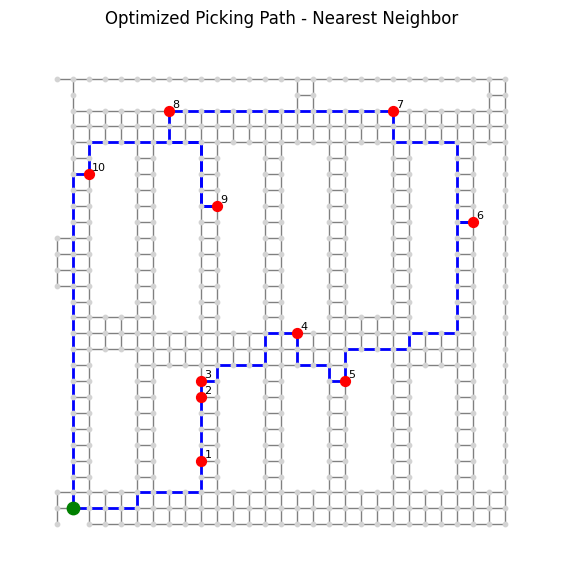

Item 1 picked at (9, 4)
Item 2 picked at (9, 8)
Item 3 picked at (9, 9)
Item 4 picked at (15, 12)
Item 5 picked at (18, 9)
Item 6 picked at (26, 19)
Item 7 picked at (21, 26)
Item 8 picked at (7, 26)
Item 9 picked at (10, 20)
Item 10 picked at (2, 22)


In [34]:
# 4. Visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Optimized Picking Path - Nearest Neighbor")

# Draw the static elements: graph and nodes (static)
nx.draw(G, pos=pos, node_size=10, node_color="lightgray", edge_color="gray", with_labels=False, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=item_locations, node_color="red", node_size=50, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=[gate_position], node_color="green", node_size=80, ax=ax)

# Label items with picking order (1-based index)
for idx, node in enumerate(optimized_order, 1):
    x, y = pos[node]
    ax.text(x + 0.2, y + 0.2, str(idx), fontsize=8, color='black')

# Draw the full optimized path
path_edges = list(zip(optimized_path, optimized_path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="blue", width=2, ax=ax)

# Display the plot
plt.show()

# Print the optimized picking order
for idx, item in enumerate(optimized_order, 1):
    print(f"Item {idx} picked at {item}")